In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os import listdir, remove
from os.path import isfile, join
import numpy as np

## Download Dataset

In [3]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("movie_reviews")

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/aksdmj/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

In [4]:
from nltk.corpus import movie_reviews as mr
from collections import defaultdict

In [5]:
# divide filenames by its sentiment
# error-avoiding method
documents = defaultdict(list)
for i in mr.fileids():
    documents[i.split('/')[0]].append(i)

In [6]:
# calculate maximum length of text
lens = [len(mr.raw(i)) for i  in mr.fileids()]
max_num_characters = max(lens)
max_num_characters

14957

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

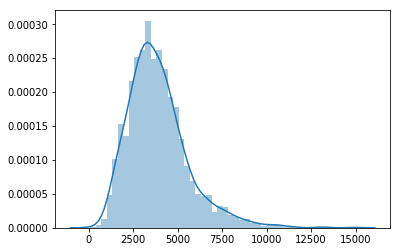

In [8]:
sns.distplot(lens)

In [9]:
# count the number of unique words used in all texts
# 70 non sapce characted is used in original paper.
unique_chars = len(set(mr.raw()))
unique_chars

74

In [10]:
chars = sorted(list(set(mr.raw())))

In [11]:
char_dict_inv = {v:i+1 for i,v in enumerate(chars)}
char_dict_inv["<PAD>"] = 0
char_dict_inv['!']

8

# Model

In [12]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

In [13]:
tfe.enable_eager_execution(device_policy=tfe.DEVICE_PLACEMENT_SILENT)

In [ ]:
device = 'gpu:0' if tfe.num_gpus() > 0 else 'cpu:0'

# Data preprocess

In [14]:
# maximum character counts
# original paper used only 1014 characters, but we will use 5000
l0 = 5000

In [15]:
def cut_or_padding(chars):
    if len(chars) > l0:
        # from back
        # return chars[-l0:]
        
        # from front
        return chars[:l0]
    else:
        return chars
def chars2indexs(chars):
    return np.array([char_dict_inv[char] for char in chars])

def preprocess(document):
    indexs = chars2indexs(cut_or_padding(mr.raw(document)))
    temp = np.concatenate([indexs, np.zeros([l0 - indexs.shape[0]], dtype="int64")])
    return temp

In [16]:
X = list()
y = list()

# 0 label for negative , 1 for positive
for i in documents['neg']:
    tx = preprocess(i)
    X.append(tx)
    y.append(0)
    
for i in documents['pos']:
    tx = preprocess(i)
    X.append(tx)
    y.append(1)

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
from charcter_cnn import CNN_character

In [19]:
charcnn = CNN_character(num_chars=len(char_dict_inv), in_dim=l0, out_dim=2, device_name=device)

In [20]:
charcnn(tf.convert_to_tensor(X_train[:1]), True)
charcnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv11 (Conv1D)              multiple                  538624    
_________________________________________________________________
conv12 (Conv1D)              multiple                  7341056   
_________________________________________________________________
conv13 (Conv1D)              multiple                  3146752   
_________________________________________________________________
conv14 (Conv1D)              multiple                  3146752   
_________________________________________________________________
conv15 (Conv1D)              multiple                  3146752   
_________________________________________________________________
conv16 (Conv1D)              multiple                  3146752   
_________________________________________________________________
maxpool1 (MaxPooling1D)      multiple                  0         
__________

In [21]:
# if you get OOM error, use smaller batch_size
charcnn.fit(X_train,y_train, X_val, y_val, epochs=20, verbose=4, batch_size=32, tqdm_option="normal")

VAL     1: 100%|██████████| 13/13 [00:11<00:00,  1.16s/it]


[EPOCH 1 / STEP 1]
TRAIN loss   : 56094.2383
VAL   loss   : 115285.3281
VAL   acc    : 49.7500%


VAL     4: 100%|██████████| 13/13 [00:10<00:00,  1.03it/s]


[EPOCH 4 / STEP 4]
TRAIN loss   : 18472.0996
VAL   loss   : 4859.9292
VAL   acc    : 50.2500%


VAL     8: 100%|██████████| 13/13 [00:10<00:00,  1.03it/s]


[EPOCH 8 / STEP 8]
TRAIN loss   : 259.4607
VAL   loss   : 282.5378
VAL   acc    : 53.5000%


VAL    12: 100%|██████████| 13/13 [00:10<00:00,  1.01s/it]


[EPOCH 12 / STEP 12]
TRAIN loss   : 418.5057
VAL   loss   : 252.0976
VAL   acc    : 46.7500%


VAL    16: 100%|██████████| 13/13 [00:11<00:00,  1.08s/it]


[EPOCH 16 / STEP 16]
TRAIN loss   : 112.7941
VAL   loss   : 146.6388
VAL   acc    : 52.2500%


VAL    20: 100%|██████████| 13/13 [00:11<00:00,  1.04s/it]


[EPOCH 20 / STEP 20]
TRAIN loss   : 40.5559
VAL   loss   : 87.1154
VAL   acc    : 53.5000%


## lets do 10 more step...

In [23]:
charcnn.fit(X_train,y_train, X_val, y_val, epochs=10, verbose=1, batch_size=32, tqdm_option="normal")

VAL    21: 100%|██████████| 13/13 [00:11<00:00,  1.04s/it]


[EPOCH 1 / STEP 21]
TRAIN loss   : 40.8943
VAL   loss   : 55.5120
VAL   acc    : 58.0000%


VAL    22: 100%|██████████| 13/13 [00:11<00:00,  1.01s/it]


[EPOCH 2 / STEP 22]
TRAIN loss   : 29.5771
VAL   loss   : 57.7745
VAL   acc    : 53.0000%


VAL    23: 100%|██████████| 13/13 [00:11<00:00,  1.02s/it]


[EPOCH 3 / STEP 23]
TRAIN loss   : 26.9711
VAL   loss   : 69.9838
VAL   acc    : 52.0000%


VAL    24: 100%|██████████| 13/13 [00:11<00:00,  1.03s/it]


[EPOCH 4 / STEP 24]
TRAIN loss   : 33.7329
VAL   loss   : 55.0650
VAL   acc    : 57.7500%


VAL    25: 100%|██████████| 13/13 [00:11<00:00,  1.05s/it]


[EPOCH 5 / STEP 25]
TRAIN loss   : 50.7456
VAL   loss   : 55.0807
VAL   acc    : 54.7500%


VAL    26: 100%|██████████| 13/13 [00:11<00:00,  1.06s/it]


[EPOCH 6 / STEP 26]
TRAIN loss   : 47.6177
VAL   loss   : 105.0159
VAL   acc    : 50.2500%


VAL    27: 100%|██████████| 13/13 [00:11<00:00,  1.06s/it]


[EPOCH 7 / STEP 27]
TRAIN loss   : 155.1989
VAL   loss   : 117.7978
VAL   acc    : 54.0000%


VAL    28: 100%|██████████| 13/13 [00:11<00:00,  1.02s/it]


[EPOCH 8 / STEP 28]
TRAIN loss   : 147.5739
VAL   loss   : 269.6201
VAL   acc    : 52.7500%


VAL    29: 100%|██████████| 13/13 [00:11<00:00,  1.06s/it]


[EPOCH 9 / STEP 29]
TRAIN loss   : 2319.7034
VAL   loss   : 2925.7612
VAL   acc    : 49.0000%


VAL    30: 100%|██████████| 13/13 [00:10<00:00,  1.03it/s]


[EPOCH 10 / STEP 30]
TRAIN loss   : 824.2751
VAL   loss   : 187.8260
VAL   acc    : 53.2500%
